CNN-LSTM

In [10]:
import tensorflow as tf  # Main library for building and training machine learning models

from tensorflow.keras.preprocessing.text import Tokenizer  # Tool for converting text to sequences of integers
from tensorflow.keras.preprocessing.text import tokenizer_from_json  # Utility to load a tokenizer from a JSON file
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Function to make all sequences in a list have the same length by padding them
from tensorflow.keras.utils import to_categorical  # Converts a class vector to binary class matrix

from tensorflow.keras.models import Sequential  # Model type in Keras that is a linear stack of layers
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense  # Layers used to build models
from tensorflow.keras.models import load_model  # Function to load a saved Keras model from disk, allowing for model reuse without retraining

from tensorflow.keras.metrics import Precision, Recall  # Metrics to measure the accuracy of model predictions
from tensorflow.keras import backend as K  # Provides the backend interface

import json  # Library for JSON operations, save tokenizer
import numpy as np  # Fundamental package for scientific computing with Python
from datasets import load_dataset  # Function to load datasets

In [11]:
# Load the dataset
dataset = load_dataset("ag_news")
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']


In [12]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [13]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
#max_length = max(len(x) for x in sequences)  # or use a fixed length
max_length = 180
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Prepare labels for training
labels = np.array(train_labels)

# Assuming `augmented_labels` 
# is a list or numpy array of integer class labels
one_hot_labels = to_categorical(train_labels, num_classes=4)


In [14]:
print(padded_sequences.shape)
print(one_hot_labels.shape)

(120000, 180)
(120000, 4)


In [15]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [16]:
# Define model (as previously setup)
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(4, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(), Precision(), Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 180, 64)           640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 178, 32)           6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 89, 32)           0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 671,268
Trainable params: 671,268
Non-trainable params: 0
________________________________________________

In [18]:
history = model.fit(padded_sequences,one_hot_labels, epochs=10, batch_size=256, validation_split=0.15, shuffle=True)

Epoch 1/10
399/399 [==============================] - 16s 39ms/step - loss: 0.2969 - accuracy: 0.9076 - f1_score: 0.9081 - precision_3: 0.9193 - recall_3: 0.8971 - val_loss: 0.3162 - val_accuracy: 0.8951 - val_f1_score: 0.8954 - val_precision_3: 0.9087 - val_recall_3: 0.8824
Epoch 2/10
399/399 [==============================] - 15s 38ms/step - loss: 0.2481 - accuracy: 0.9238 - f1_score: 0.9244 - precision_3: 0.9324 - recall_3: 0.9164 - val_loss: 0.3191 - val_accuracy: 0.8953 - val_f1_score: 0.8952 - val_precision_3: 0.9071 - val_recall_3: 0.8836
Epoch 3/10
399/399 [==============================] - 15s 38ms/step - loss: 0.2183 - accuracy: 0.9345 - f1_score: 0.9346 - precision_3: 0.9401 - recall_3: 0.9290 - val_loss: 0.3138 - val_accuracy: 0.8937 - val_f1_score: 0.8943 - val_precision_3: 0.9028 - val_recall_3: 0.8859
Epoch 4/10
399/399 [==============================] - 15s 38ms/step - loss: 0.1896 - accuracy: 0.9449 - f1_score: 0.9449 - precision_3: 0.9484 - recall_3: 0.9414 - val_loss

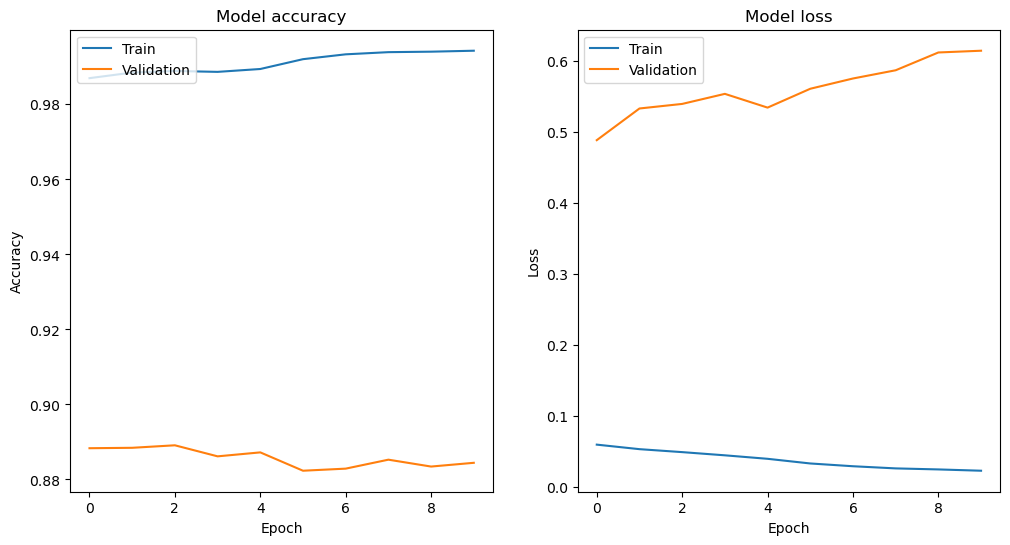

In [ ]:
import matplotlib.pyplot as plt

# Assuming `history` is the output from the model.fit() method
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
#Save the model
model_save_path = "BASE_CNN-LSTM_classifier_model.h5"
model.save(model_save_path) 

# Serialize tokenizer to a JSON string
tokenizer_json = tokenizer.to_json()

# Save the tokenizer JSON string to a file
with open("tokenizer_BASE.json", 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
BASE_CNN_LSTM = load_model("BASE_CNN-LSTM_classifier_model.h5", custom_objects={'F1Score': F1Score})  # Load the model

# Load tokenizer from JSON file
with open("tokenizer_BASE.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [ ]:
print(max_length)

180


In [ ]:
# Example of preparing test data (replace 'test_texts' with dataset["test"] data)
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

test_labels = np.array(test_labels)
test_one_hot_labels = to_categorical(test_labels, num_classes=4)

# Evaluate the model
loss, accuracy, f1, precision, recall = BASE_CNN_LSTM.evaluate(test_padded_sequences, test_one_hot_labels)
print(f'Test accuracy: {accuracy}, Test F1 Score: {f1}, Precision: {precision}, Recall: {recall}')

2024-05-10 19:22:08.241520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-05-10 19:22:08.422737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


238/238 [==============================] - 9s 33ms/step - loss: 0.5589 - accuracy: 0.8926 - f1_score: 0.8926 - precision_3: 0.8937 - recall_3: 0.8914
Test accuracy: 0.8926315903663635, Test F1 Score: 0.892562985420227, Precision: 0.8936815857887268, Recall: 0.8914473652839661
